<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Сегментация изображений

В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>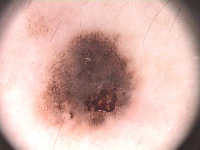</td><td>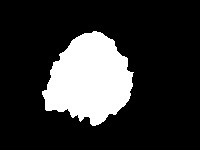</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
!nvidia-smi

Tue May 18 19:59:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch

torch.backends.cudnn.enabled

True

In [3]:
seed = 42

import random
random.seed(seed)

import numpy as np
np.random.seed(seed)

import torch

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [5]:
!unrar x -idq  "/content/gdrive/My Drive/PH2Dataset.rar"

In [6]:
!ls -alh

total 24K
drwxr-xr-x 1 root root 4.0K May 18 19:59 .
drwxr-xr-x 1 root root 4.0K May 18 19:57 ..
drwxr-xr-x 4 root root 4.0K May  6 13:43 .config
drwx------ 5 root root 4.0K May 18 19:59 gdrive
drwxr-xr-x 3 root root 4.0K May  3 05:12 PH2Dataset
drwxr-xr-x 1 root root 4.0K May  6 13:44 sample_data


Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [7]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [8]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [9]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

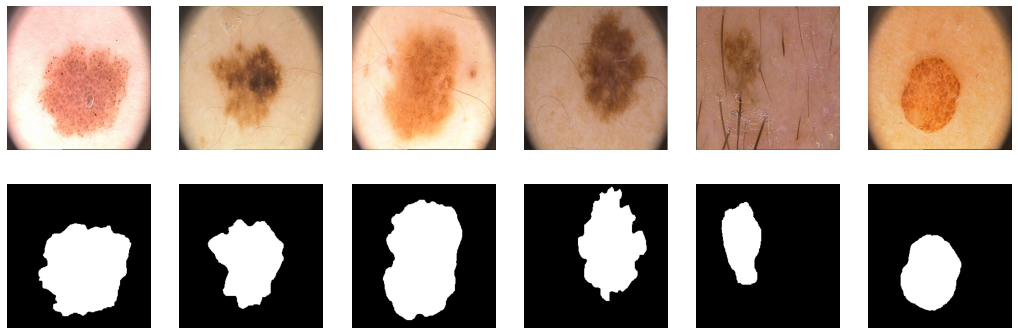

In [10]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis('off')
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis('off')
    plt.imshow(Y[i], cmap='gray')
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [11]:
ix = np.random.choice(len(X), len(X), False)
train, val, test = np.split(ix, [100, 150])

In [12]:
print(len(train), len(val), len(test))

100 50 50


#### Data Augmentation using Albumentations

In [13]:
import albumentations as A

transform = A.Compose([
    A.HorizontalFlip(p=1),
    A.VerticalFlip(p=0.6),
    A.RandomRotate90(p=0.6)],
    additional_targets={'image_mask': 'mask'}
)

##### Train augmentation

In [14]:
from tqdm.notebook import tqdm

X_train_augmented = []
y_train_augmented = []

for index in tqdm(train):

  transformed = transform(image=X[index], image_mask=Y[index])
  transformed_image = transformed['image']
  transformed_mask = transformed['image_mask']
  
  X_train_augmented.append(transformed_image)
  y_train_augmented.append(transformed_mask)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

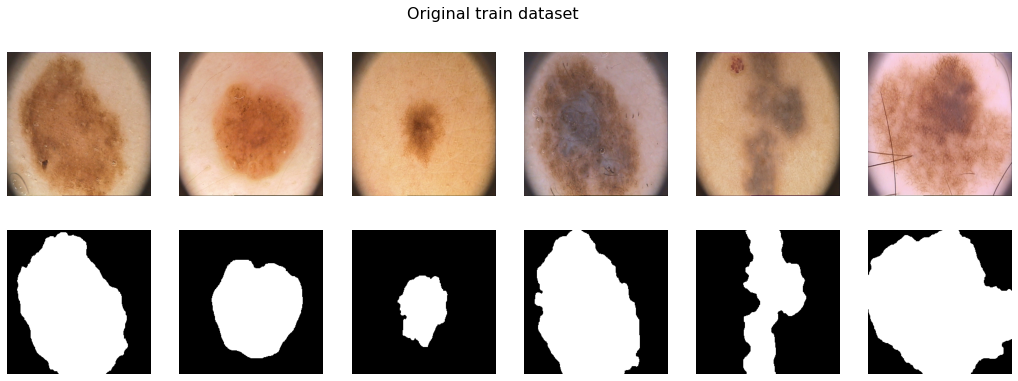

In [15]:
fig = plt.figure(figsize=(18, 6))
fig.suptitle('Original train dataset', fontsize=16)

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis('off')
    plt.imshow(X[train][i])

    plt.subplot(2, 6, i+7)
    plt.axis('off')
    plt.imshow(Y[train][i], cmap='gray')
    plt.xlabel(i)

plt.show()

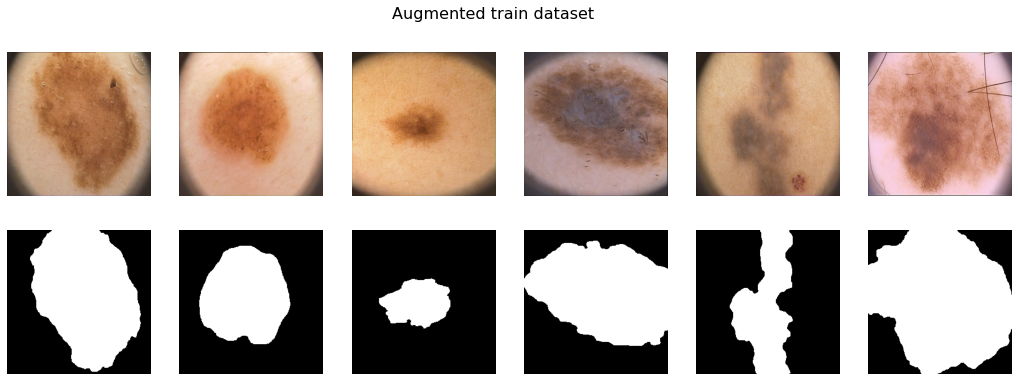

In [16]:
fig = plt.figure(figsize=(18, 6))
fig.suptitle('Augmented train dataset', fontsize=16)

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis('off')
    plt.imshow(X_train_augmented[i])

    plt.subplot(2, 6, i+7)
    plt.axis('off')
    plt.imshow(y_train_augmented[i], cmap='gray')

plt.show()

##### Valid augmentation

In [17]:
from tqdm.notebook import tqdm

X_val_augmented = []
y_val_augmented = []

for index in tqdm(val):

  transformed = transform(image=X[index], image_mask=Y[index])
  transformed_image = transformed['image']
  transformed_mask = transformed['image_mask']
  
  X_val_augmented.append(transformed_image)
  y_val_augmented.append(transformed_mask)

X_val_augmented = np.array(X_val_augmented)
y_val_augmented = np.array(y_val_augmented)

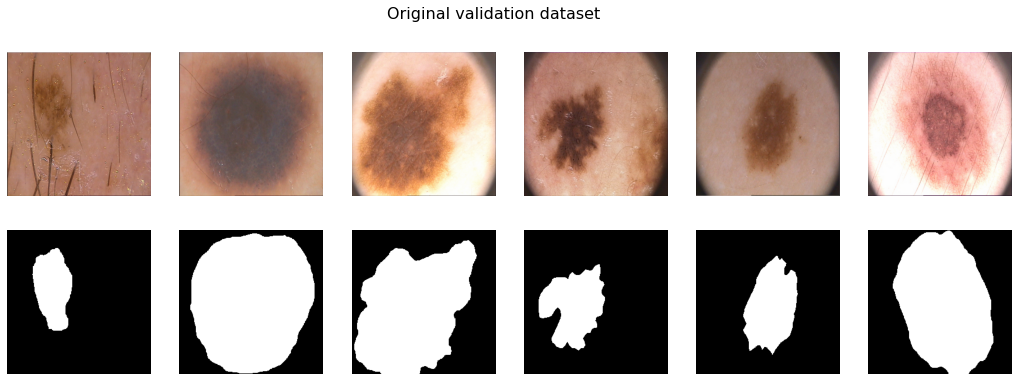

In [18]:
fig = plt.figure(figsize=(18, 6))
fig.suptitle('Original validation dataset', fontsize=16)

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis('off')
    plt.imshow(X[val][i])

    plt.subplot(2, 6, i+7)
    plt.axis('off')
    plt.imshow(Y[val][i], cmap='gray')
    plt.xlabel(i)

plt.show()

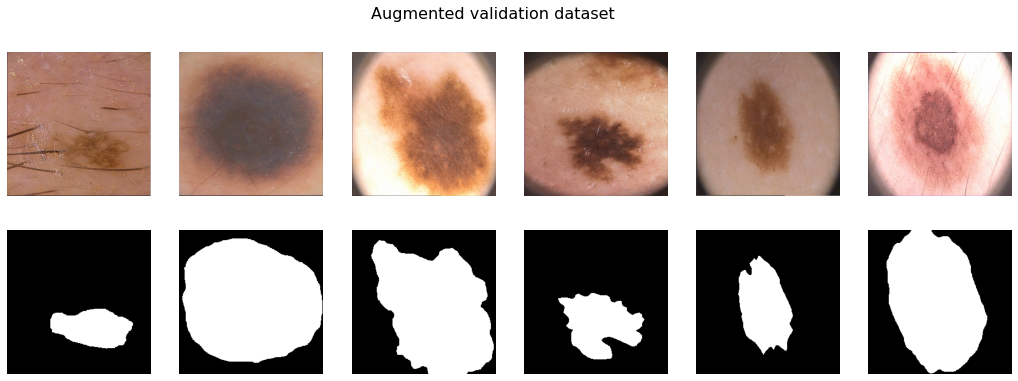

In [19]:
fig = plt.figure(figsize=(18, 6))
fig.suptitle('Augmented validation dataset', fontsize=16)

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis('off')
    plt.imshow(X_val_augmented[i])

    plt.subplot(2, 6, i+7)
    plt.axis('off')
    plt.imshow(y_val_augmented[i], cmap='gray')

plt.show()

##### Concatenate original and augmented datasets

In [20]:
X_train_full = np.concatenate([X[train], X_train_augmented])
y_train_full = np.concatenate([Y[train], y_train_augmented])

X_val_full = np.concatenate([X[val], X_val_augmented])
y_val_full = np.concatenate([Y[val], y_val_augmented])

In [21]:
print(len(X_train_full), len(X_val_full), len(test))

200 100 50


#### PyTorch DataLoader

In [22]:
from torch.utils.data import DataLoader

batch_size = 25

data_tr = DataLoader(list(zip(np.rollaxis(X_train_full, 3, 1), y_train_full[:, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X_val_full, 3, 1), y_val_full[:, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[test], 3, 1), Y[test, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [23]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

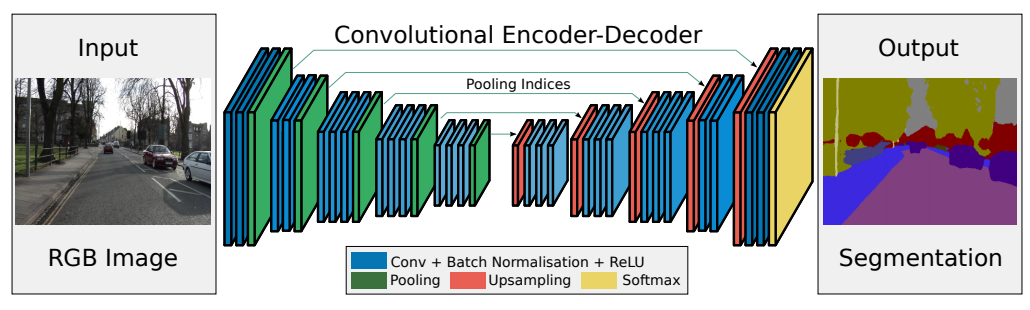

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim

from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [25]:
class Conv2DBatchNormRelu(nn.Module):
	def __init__(
	    self,
	    in_channels,
	    n_filters,
	    kernel_size,
	    stride,
	    padding,
	    bias=True,
	    dilation=1,
	    with_bn=True,
	):
	    super(Conv2DBatchNormRelu, self).__init__()

	    conv_layer = nn.Conv2d(
	    	int(in_channels),
	    	int(n_filters),
	    	kernel_size=kernel_size,
	    	padding=padding,
	    	stride=stride,
	    	bias=bias,
	    	dilation=1,
	    )

	    self.layer = nn.Sequential(
	    	conv_layer, nn.BatchNorm2d(int(n_filters)), nn.ReLU(inplace=True)
	    )

	def forward(self, inputs):
	    return self.layer(inputs)

In [26]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            Conv2DBatchNormRelu(in_channels=3, n_filters=32, kernel_size=3, stride=1, padding=1),
            Conv2DBatchNormRelu(in_channels=32, n_filters=32, kernel_size=3, stride=1, padding=1)
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.enc_conv1 = nn.Sequential(
            Conv2DBatchNormRelu(in_channels=32, n_filters=64, kernel_size=3, stride=1, padding=1),
            Conv2DBatchNormRelu(in_channels=64, n_filters=64, kernel_size=3, stride=1, padding=1)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            Conv2DBatchNormRelu(in_channels=64, n_filters=128, kernel_size=3, stride=1, padding=1),
            Conv2DBatchNormRelu(in_channels=128, n_filters=128, kernel_size=3, stride=1, padding=1)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.enc_conv3 = nn.Sequential(
            Conv2DBatchNormRelu(in_channels=128, n_filters=256, kernel_size=3, stride=1, padding=1),
            Conv2DBatchNormRelu(in_channels=256, n_filters=256, kernel_size=3, stride=1, padding=1)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
      
        self.bottleneck_conv = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1)

        self.upsample0 = nn.MaxUnpool2d(2, 2)
        self.dec_conv0 = nn.Sequential(
            Conv2DBatchNormRelu(in_channels=256, n_filters=256, kernel_size=3, stride=1, padding=1),
            Conv2DBatchNormRelu(in_channels=256, n_filters=128, kernel_size=3, stride=1, padding=1)
        )

        self.upsample1 = nn.MaxUnpool2d(2, 2)
        self.dec_conv1 = nn.Sequential(
            Conv2DBatchNormRelu(in_channels=128, n_filters=128, kernel_size=3, stride=1, padding=1),
            Conv2DBatchNormRelu(in_channels=128, n_filters=64, kernel_size=3, stride=1, padding=1)
        )

        self.upsample2 = nn.MaxUnpool2d(2, 2)
        self.dec_conv2 = nn.Sequential(
            Conv2DBatchNormRelu(in_channels=64, n_filters=64, kernel_size=3, stride=1, padding=1),
            Conv2DBatchNormRelu(in_channels=64, n_filters=32, kernel_size=3, stride=1, padding=1)
        )

        self.upsample3 = nn.MaxUnpool2d(2, 2)
        self.dec_conv3 = nn.Sequential(
            Conv2DBatchNormRelu(in_channels=32, n_filters=32, kernel_size=3, stride=1, padding=1),
            Conv2DBatchNormRelu(in_channels=32, n_filters=1, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        
        # encoder
        e0, indices0 = self.pool0(self.enc_conv0(x))
        e1, indices1 = self.pool1(self.enc_conv1(e0))
        e2, indices2 = self.pool2(self.enc_conv2(e1))
        e3, indices3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b, indices3))
        d1 = self.dec_conv1(self.upsample1(d0, indices2))
        d2 = self.dec_conv2(self.upsample2(d1, indices1))
        d3 = self.dec_conv3(self.upsample3(d2, indices0))  # no activation
        
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [27]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
  
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    eps = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + eps) / (union + eps)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [28]:
def bce_loss(y_real, y_pred):
    return torch.mean(y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred)))

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [29]:
def train(model, optimizer, loss_fn, epochs, data_tr, data_val, scheduler=None):
    X_val, Y_val = next(iter(data_val))

    history = []
    train_iou = []
    val_iou = []
    
    for epoch in tqdm(range(epochs)):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            optimizer.zero_grad()

            # forward
            Y_pred = model(X_batch)
            
            loss = loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            
            optimizer.step()  # update weights

            if scheduler is not None:
              scheduler.step()

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        
        toc = time()
        print('loss: %f' % avg_loss)
        
        history.append(avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.to(device)).detach().cpu().numpy() # detach and put into cpu
        
        train_iou.append(score_model(model, iou_pytorch, data_tr))
        val_iou.append(score_model(model, iou_pytorch, data_val))

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):

            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0] > 0.5, cmap='gray')
            plt.title('Output')
            plt.axis('off')
        
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
    
    return history, train_iou, val_iou

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [30]:
def predict(model, data):
    
    model.eval()  # eval mode
    Y_pred = [ X_batch for X_batch, _ in data]
    
    return np.array(Y_pred)

In [31]:
def score_model(model, metric, data):
    
    model.eval()  # eval mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = torch.sigmoid(model(X_batch.to(device))) > 0.5  # was added sigmoid and " > 0.5"
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [32]:
model_segnet = SegNet().to(device)

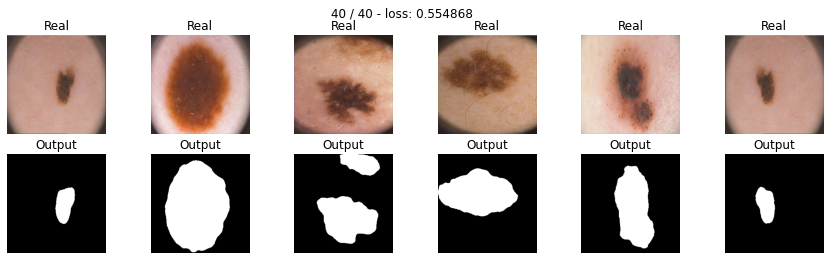


CPU times: user 3min 18s, sys: 844 ms, total: 3min 19s
Wall time: 3min 20s


In [33]:
%%time

max_epochs = 40

optimizer = optim.AdamW(model_segnet.parameters(), lr=3e-4)

# optimizer = optim.AdamW(model_segnet.parameters(), lr=5e-4)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

history_segnet, tr_iou_segnet, val_iou_segnet = train(model_segnet, optimizer, bce_loss, max_epochs, data_tr, data_val)

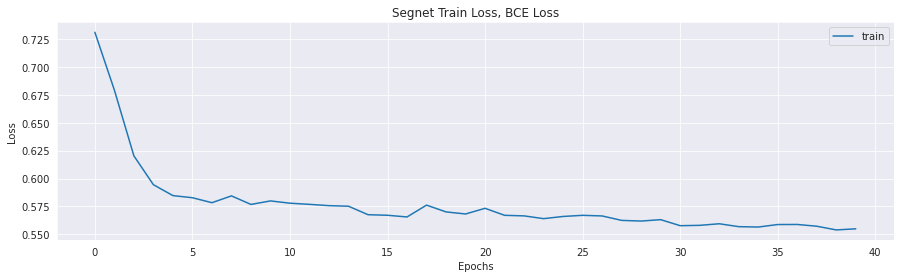

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

plt.plot(range(40), history_segnet, label='train')
plt.title('Segnet Train Loss, BCE Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
segnet_score_val = score_model(model_segnet, iou_pytorch, data_val)
print(segnet_score_val)

0.6500000059604645


In [36]:
segnet_score_test = score_model(model_segnet, iou_pytorch, data_ts)
print(segnet_score_test)

0.6740000247955322


Ответьте себе на вопрос: не переобучается ли моя модель?

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [37]:
def dice_loss(y_real, y_pred, eps=1e-8):

    y_pred = torch.clamp(torch.sigmoid(y_pred), min=eps, max=1-eps)
    loss = 1 - torch.mean(2 * (y_real * y_pred) / ((y_real + y_pred)))
    
    return loss

Проводим тестирование:

In [38]:
torch.cuda.empty_cache()

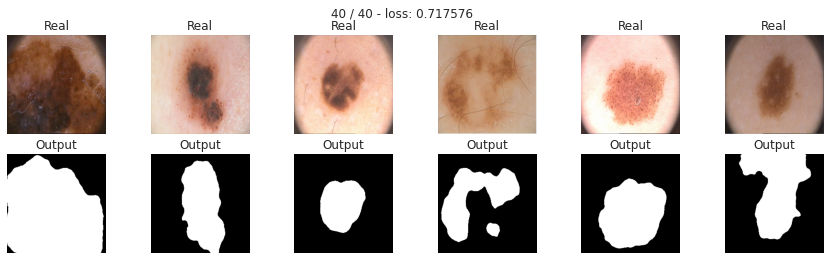


CPU times: user 4min 4s, sys: 1.46 s, total: 4min 6s
Wall time: 4min 5s


In [39]:
%%time

model_dice = SegNet().to(device)

max_epochs = 40

optimizer = optim.AdamW(model_dice.parameters(), lr=3e-4)
history_dice, tr_iou_dice, val_iou_dice = train(model_dice, optimizer, dice_loss, max_epochs, data_tr, data_val)

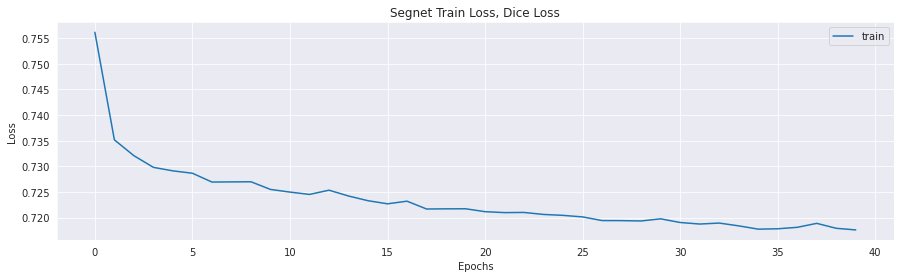

In [40]:
plt.plot(range(40), history_dice, label='train')
plt.title('Segnet Train Loss, Dice Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [41]:
dice_score = score_model(model_dice, iou_pytorch, data_val)
print(dice_score)

0.7189999967813492


In [42]:
dice_score = score_model(model_dice, iou_pytorch, data_ts)
print(dice_score)

0.7339999973773956


[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [43]:
def focal_loss(y_real, y_pred, eps=1e-7, gamma=2):

    y_pred = torch.clamp(torch.sigmoid(y_pred), min=eps, max=1-eps) # hint: torch.clamp
    loss = -torch.mean((1 - y_pred)**gamma * y_real * torch.log(y_pred) + (1 - y_real) * torch.log(1 - y_pred))
    
    return loss

In [44]:
torch.cuda.empty_cache()

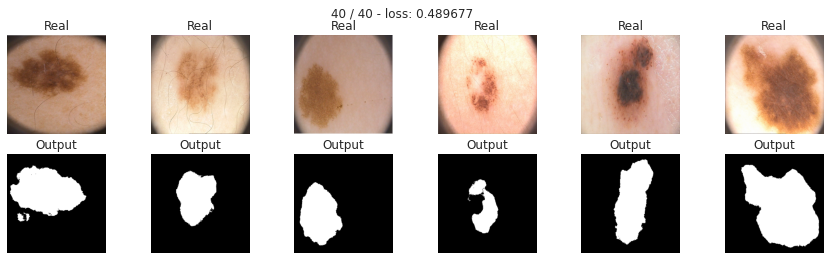


CPU times: user 4min 4s, sys: 1.49 s, total: 4min 5s
Wall time: 4min 5s


In [45]:
%%time

model_focal = SegNet().to(device)

max_epochs = 40

optimizer = optim.AdamW(model_focal.parameters(), lr=3e-4)
history_focal, tr_iou_focal, val_iou_focal = train(model_focal, optimizer, focal_loss, max_epochs, data_tr, data_val)

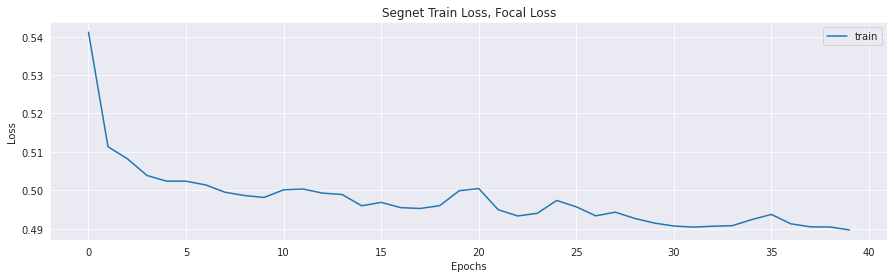

In [46]:
plt.plot(range(40), history_focal, label='train')
plt.title('Segnet Train Loss, Focal Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [47]:
focal_score = score_model(model_focal, iou_pytorch, data_val)
print(focal_score)

0.6729999929666519


In [48]:
focal_score = score_model(model_focal, iou_pytorch, data_ts)
print(focal_score)

0.6820000112056732


[**3. Комбинированный loss:**] BCE + Dice + Focal

In [49]:
def ensemble_loss(y_real, y_pred):

    bce_loss_part = bce_loss(y_real, y_pred)
    dice_loss_part = dice_loss(y_real, y_pred)
    focal_loss_part = focal_loss(y_real, y_pred)

    loss = bce_loss_part + dice_loss_part + focal_loss_part

    return loss

In [50]:
torch.cuda.empty_cache()

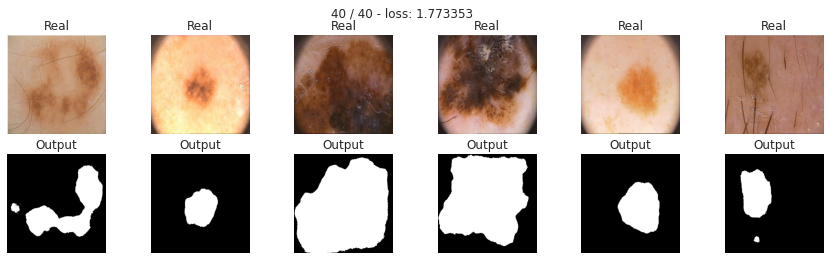


CPU times: user 4min 1s, sys: 5.41 s, total: 4min 6s
Wall time: 4min 6s


In [51]:
%%time

model_ensemble = SegNet().to(device)

max_epochs = 40

optimizer = optim.AdamW(model_ensemble.parameters(), lr=3e-4)
history_ensemble, tr_iou_ensemble, val_iou_ensemble = train(model_ensemble, optimizer, ensemble_loss, max_epochs, data_tr, data_val)

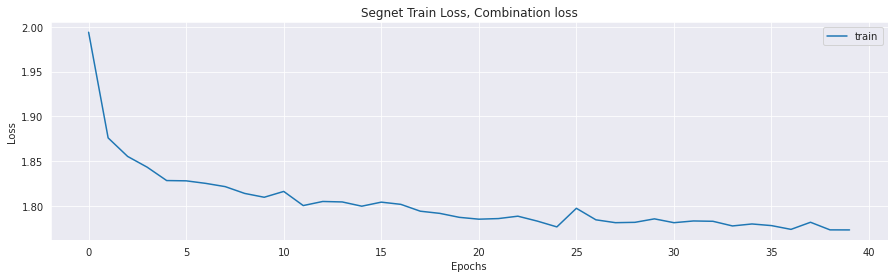

In [52]:
plt.plot(range(40), history_ensemble, label='train')
plt.title('Segnet Train Loss, Combination loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [53]:
ensemble_score = score_model(model_ensemble, iou_pytorch, data_val)
print(ensemble_score)

0.7239999920129776


In [54]:
ensemble_score = score_model(model_ensemble, iou_pytorch, data_ts)
print(ensemble_score)

0.7599999904632568


----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

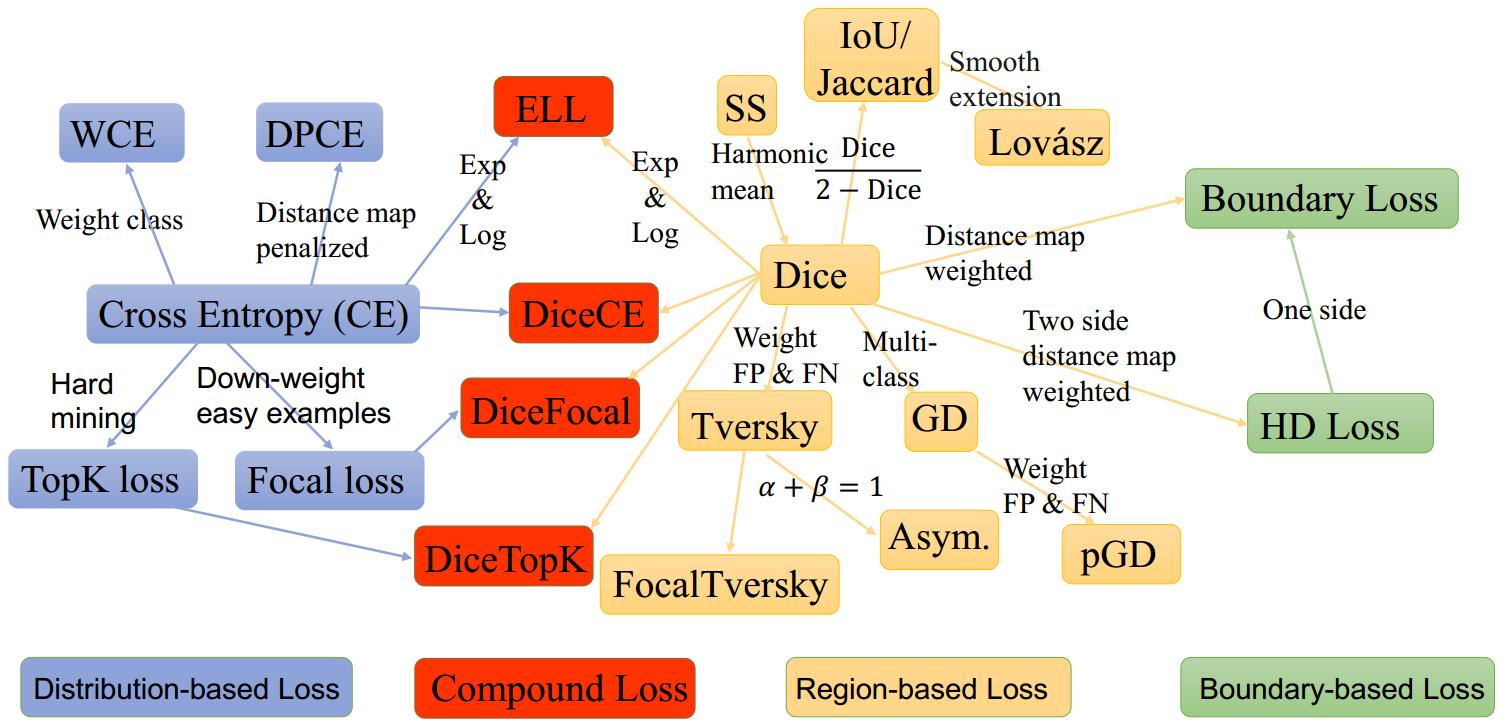

**Tversky loss:** This loss was introduced in "Tversky loss function for image segmentationusing 3D fully convolutional deep networks", retrievable here: https://arxiv.org/abs/1706.05721. It was designed to optimise segmentation on imbalanced medical datasets by utilising constants that can adjust how harshly different types of error are penalised in the loss function. From the paper:

... in the case of α=β=0.5 the Tversky index simplifies to be the same as the Dice coefficient, which is also equal to the F1 score. With α=β=1, Equation 2 produces Tanimoto coefficient, and setting α+β=1 produces the set of Fβ scores. Larger βs weigh recall higher than precision (by placing more emphasis on false negatives).

To summarise, this loss function is weighted by the constants 'alpha' and 'beta' that penalise false positives and false negatives respectively to a higher degree in the loss function as their value is increased. The beta constant in particular has applications in situations where models can obtain misleadingly positive performance via highly conservative prediction. You may want to experiment with different values to find the optimum. With $\alpha=\beta=0.5$, this loss becomes equivalent to Dice Loss.

In [55]:
def tversky_loss(y_real, y_pred, beta=0.1, eps=1e-8):
    
  """Вычисляет Tversky loss [1].
  Args:
      alpha: controls the penalty for false positives.
      beta: controls the penalty for false negatives.
      eps: added to the denominator for numerical stability.
  Returns:
      loss: the Tversky loss.
  Notes:
      alpha = beta = 0.5 => dice coeff
      alpha = beta = 1 => tanimoto coeff
      alpha + beta = 1 => F beta coeff
  References:
      [1]: https://arxiv.org/abs/1706.05721
  """

  alpha = 1 - beta

  y_pred = torch.clamp(torch.sigmoid(y_pred), min=eps, max=1-eps) # hint: torch.clamp

  TP = torch.sum(y_real * y_pred) 
  FP = torch.sum(y_pred * (1 - y_real))
  FN = torch.sum((1 - y_pred) * y_real)

  loss = 1 - TP / (TP + alpha*FP + beta*FN)

  return loss 

In [56]:
torch.cuda.empty_cache()

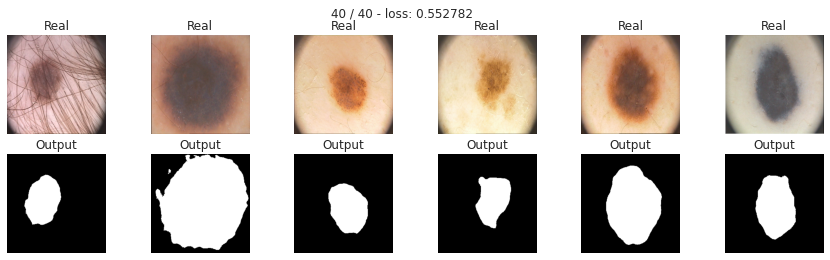


CPU times: user 4min 3s, sys: 1.56 s, total: 4min 5s
Wall time: 4min 5s


In [57]:
%%time

model_tversky = SegNet().to(device)

max_epochs = 40

optimizer = optim.AdamW(model_tversky.parameters(), lr=3e-4)
history_tversky, tr_iou_tversky, val_iou_tversky = train(model_tversky, optimizer, tversky_loss, max_epochs, data_tr, data_val)

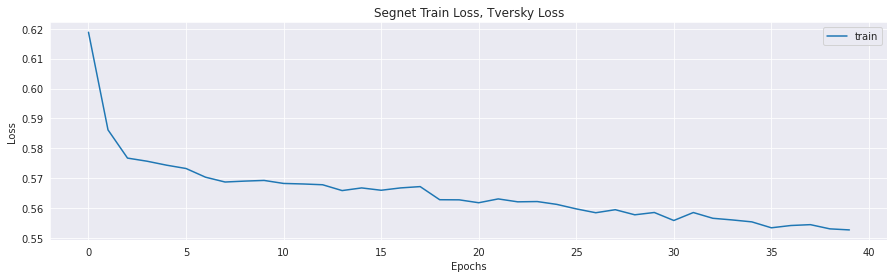

In [58]:
plt.plot(range(40), history_tversky, label='train')
plt.title('Segnet Train Loss, Tversky Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [59]:
tversky_score = score_model(model_tversky, iou_pytorch, data_val)
print(tversky_score)

0.7489999830722809


In [60]:
tversky_score = score_model(model_tversky, iou_pytorch, data_ts)
print(tversky_score)

0.7599999606609344


**Jaccard loss:** 

In [61]:
def jaccard_loss(y_real, y_pred, eps=1e-8):

    y_pred = torch.clamp(torch.sigmoid(y_pred), min=eps, max=1-eps)
    loss = 1 - torch.sum(y_pred * y_real) / (torch.sum(y_pred) + torch.sum(y_real) - torch.sum(y_pred * y_real))
    
    return loss

In [62]:
torch.cuda.empty_cache()

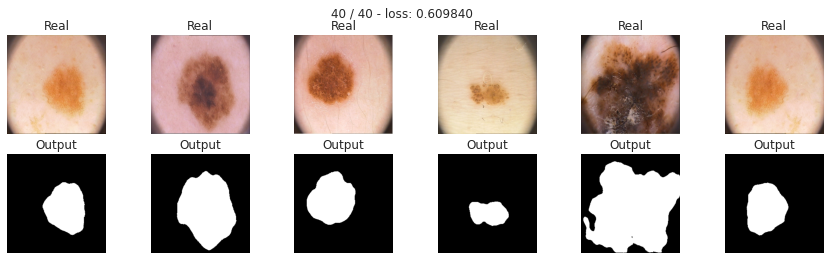


CPU times: user 4min 5s, sys: 1.5 s, total: 4min 6s
Wall time: 4min 6s


In [63]:
%%time

model_jaccard = SegNet().to(device)

max_epochs = 40

optimizer = optim.AdamW(model_jaccard.parameters(), lr=3e-4)
history_jaccard, tr_iou_jaccard, val_iou_jaccard = train(model_jaccard, optimizer, jaccard_loss, max_epochs, data_tr, data_val)

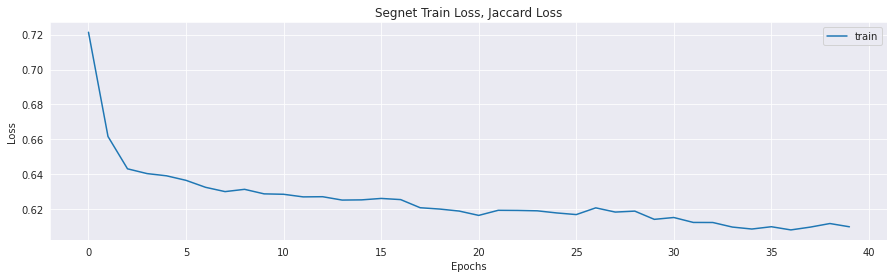

In [64]:
plt.plot(range(40), history_jaccard, label='train')
plt.title('Segnet Train Loss, Jaccard Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [65]:
jaccard_score = score_model(model_jaccard, iou_pytorch, data_val)
print(jaccard_score)

0.7360000014305115


In [66]:
jaccard_score = score_model(model_jaccard, iou_pytorch, data_ts)
print(jaccard_score)

0.7600000202655792


-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

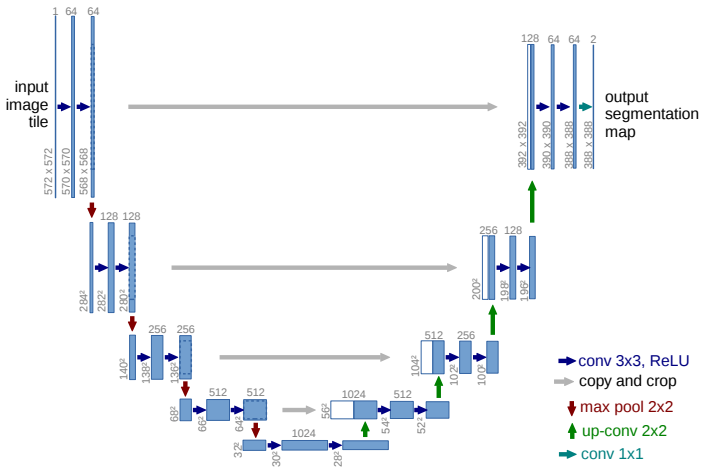

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [67]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            Conv2DBatchNormRelu(in_channels=3, n_filters=32, kernel_size=3, stride=1, padding=1),
            Conv2DBatchNormRelu(in_channels=32, n_filters=32, kernel_size=3, stride=1, padding=1)
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            Conv2DBatchNormRelu(in_channels=32, n_filters=64, kernel_size=3, stride=1, padding=1),
            Conv2DBatchNormRelu(in_channels=64, n_filters=64, kernel_size=3, stride=1, padding=1)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            Conv2DBatchNormRelu(in_channels=64, n_filters=128, kernel_size=3, stride=1, padding=1),
            Conv2DBatchNormRelu(in_channels=128, n_filters=128, kernel_size=3, stride=1, padding=1)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            Conv2DBatchNormRelu(in_channels=128, n_filters=256, kernel_size=3, stride=1, padding=1),
            Conv2DBatchNormRelu(in_channels=256, n_filters=256, kernel_size=3, stride=1, padding=1)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 32 -> 16
      
        self.bottleneck_conv = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1)

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            Conv2DBatchNormRelu(in_channels=512, n_filters=128, kernel_size=3, stride=1, padding=1),
            Conv2DBatchNormRelu(in_channels=128, n_filters=128, kernel_size=3, stride=1, padding=1)
        )

        self.upsample1 = nn.MaxUnpool2d(2, 2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            Conv2DBatchNormRelu(in_channels=256, n_filters=64, kernel_size=3, stride=1, padding=1),
            Conv2DBatchNormRelu(in_channels=64, n_filters=64, kernel_size=3, stride=1, padding=1)
        )

        self.upsample2 = nn.MaxUnpool2d(2, 2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            Conv2DBatchNormRelu(in_channels=128, n_filters=32, kernel_size=3, stride=1, padding=1),
            Conv2DBatchNormRelu(in_channels=32, n_filters=32, kernel_size=3, stride=1, padding=1)
        )

        self.upsample3 = nn.MaxUnpool2d(2, 2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            Conv2DBatchNormRelu(in_channels=64, n_filters=32, kernel_size=3, stride=1, padding=1),
            Conv2DBatchNormRelu(in_channels=32, n_filters=1, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        # encoder
        e0, indices0 = self.pool0(self.enc_conv0(x))
        e1, indices1 = self.pool1(self.enc_conv1(e0))
        e2, indices2 = self.pool2(self.enc_conv2(e1))
        e3, indices3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(torch.cat([e3, b], dim=1), torch.cat([indices3, indices3], dim=1)))
        d1 = self.dec_conv1(self.upsample1(torch.cat([e2, d0], dim=1), torch.cat([indices2, indices2], dim=1)))
        d2 = self.dec_conv2(self.upsample2(torch.cat([e1, d1], dim=1), torch.cat([indices1, indices1], dim=1)))
        d3 = self.dec_conv3(self.upsample3(torch.cat([e0, d2], dim=1), torch.cat([indices0, indices0], dim=1)))  # no activation
        return d3      

In [68]:
torch.cuda.empty_cache()

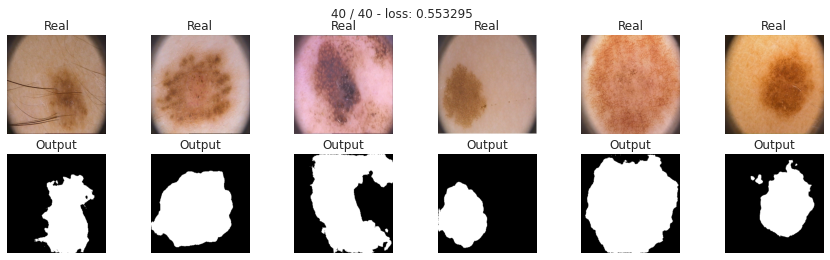


CPU times: user 4min 21s, sys: 1.49 s, total: 4min 22s
Wall time: 4min 22s


In [69]:
%%time

unet_model = UNet().to(device)

max_epochs = 40

optimizer = optim.AdamW(unet_model.parameters(), lr=3e-4)
history_unet, tr_iou_unet, val_iou_unet = train(unet_model, optimizer, bce_loss, max_epochs, data_tr, data_val)

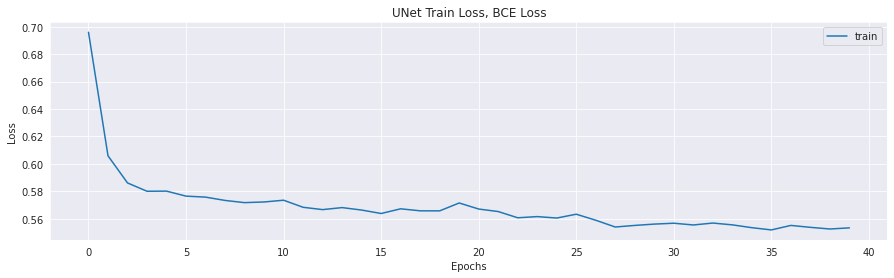

In [70]:
plt.plot(range(40), history_unet, label='train')
plt.title('UNet Train Loss, BCE Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [71]:
unet_score = score_model(unet_model, iou_pytorch, data_val)
print(unet_score)

0.6999999731779099


In [72]:
unet_score = score_model(unet_model, iou_pytorch, data_ts)
print(unet_score)

0.7059999704360962


Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [73]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            Conv2DBatchNormRelu(in_channels=3, n_filters=32, kernel_size=3, stride=1, padding=1),
            Conv2DBatchNormRelu(in_channels=32, n_filters=32, kernel_size=3, stride=1, padding=1)
        )
        self.pool0 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=2, stride=2)

        self.enc_conv1 = nn.Sequential(
            Conv2DBatchNormRelu(in_channels=32, n_filters=64, kernel_size=3, stride=1, padding=1),
            Conv2DBatchNormRelu(in_channels=64, n_filters=64, kernel_size=3, stride=1, padding=1)
        )
        self.pool1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=2)

        self.enc_conv2 = nn.Sequential(
            Conv2DBatchNormRelu(in_channels=64, n_filters=128, kernel_size=3, stride=1, padding=1),
            Conv2DBatchNormRelu(in_channels=128, n_filters=128, kernel_size=3, stride=1, padding=1)
        )
        self.pool2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=2)

        self.enc_conv3 = nn.Sequential(
            Conv2DBatchNormRelu(in_channels=128, n_filters=256, kernel_size=3, stride=1, padding=1),
            Conv2DBatchNormRelu(in_channels=256, n_filters=256, kernel_size=3, stride=1, padding=1)
        )
        self.pool3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2, stride=2)
      
        self.bottleneck_conv = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1)

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2)
        self.dec_conv0 = nn.Sequential(
            Conv2DBatchNormRelu(in_channels=512, n_filters=128, kernel_size=3, stride=1, padding=1),
            Conv2DBatchNormRelu(in_channels=128, n_filters=128, kernel_size=3, stride=1, padding=1)
        )

        self.upsample1 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2)
        self.dec_conv1 = nn.Sequential(
            Conv2DBatchNormRelu(in_channels=256, n_filters=64, kernel_size=3, stride=1, padding=1),
            Conv2DBatchNormRelu(in_channels=64, n_filters=64, kernel_size=3, stride=1, padding=1)
        )

        self.upsample2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2)
        self.dec_conv2 = nn.Sequential(
            Conv2DBatchNormRelu(in_channels=128, n_filters=32, kernel_size=3, stride=1, padding=1),
            Conv2DBatchNormRelu(in_channels=32, n_filters=32, kernel_size=3, stride=1, padding=1)
        )

        self.upsample3 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2)
        self.dec_conv3 = nn.Sequential(
            Conv2DBatchNormRelu(in_channels=64, n_filters=32, kernel_size=3, stride=1, padding=1),
            Conv2DBatchNormRelu(in_channels=32, n_filters=1, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        # print(torch.cat([e3, b], dim=1).shape, indices3.shape)
        d0 = self.dec_conv0(self.upsample0(torch.cat([e3, b], dim=1)))
        d1 = self.dec_conv1(self.upsample1(torch.cat([e2, d0], dim=1)))
        d2 = self.dec_conv2(self.upsample2(torch.cat([e1, d1], dim=1)))
        d3 = self.dec_conv3(self.upsample3(torch.cat([e0, d2], dim=1)))  # no activation
        return d3      

In [74]:
torch.cuda.empty_cache()

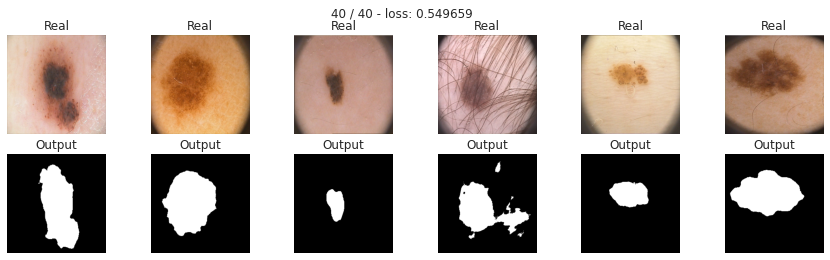


CPU times: user 4min 20s, sys: 38.2 s, total: 4min 59s
Wall time: 4min 59s


In [75]:
%%time

unet2_model = UNet2().to(device)

max_epochs = 40

optimizer = optim.AdamW(unet2_model.parameters(), lr=3e-4)
history_unet2, tr_iou_unet2, val_iou_unet2 = train(unet2_model, optimizer, bce_loss, max_epochs, data_tr, data_val)

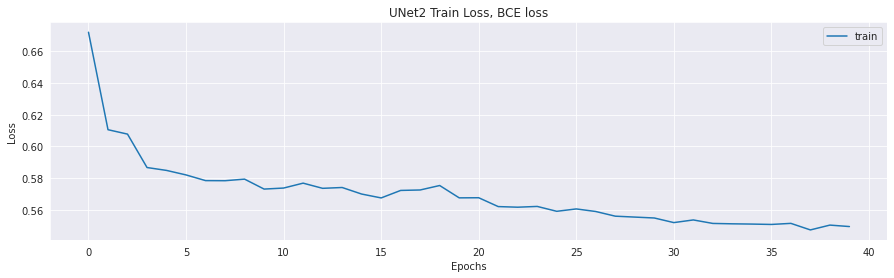

In [76]:
plt.plot(range(40), history_unet2, label='train')
plt.title('UNet2 Train Loss, BCE loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [77]:
unet2_score = score_model(unet2_model, iou_pytorch, data_val)
print(unet_score)

0.7059999704360962


In [78]:
unet2_score = score_model(unet2_model, iou_pytorch, data_ts)
print(unet_score)

0.7059999704360962


In [79]:
torch.cuda.empty_cache()

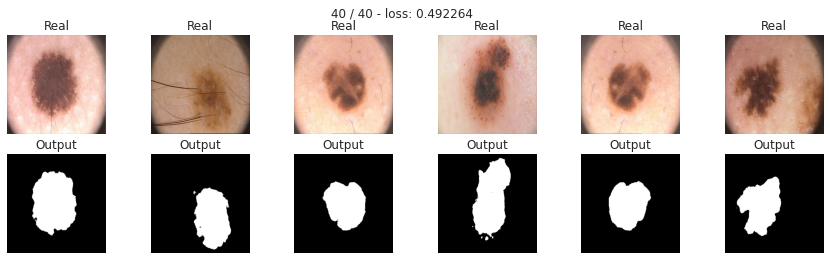


CPU times: user 4min 20s, sys: 1.51 s, total: 4min 22s
Wall time: 4min 22s


In [80]:
%%time

unet_focal = UNet().to(device)

max_epochs = 40

optimizer = optim.AdamW(unet_focal.parameters(), lr=3e-4)
history_unet_focal, tr_iou_unet_focal, val_iou_unet_focal = train(unet_focal, optimizer, focal_loss, max_epochs, data_tr, data_val)

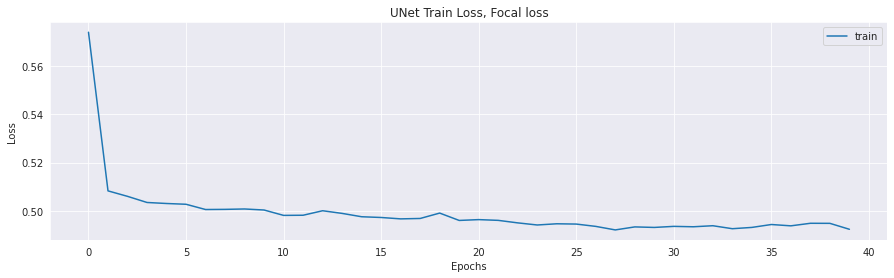

In [81]:
plt.plot(range(40), history_unet_focal, label='train')
plt.title('UNet Train Loss, Focal loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [82]:
unet_focal_score = score_model(unet_focal, iou_pytorch, data_val)
print(unet_focal_score)

0.6389999985694885


In [83]:
unet_focal_score = score_model(unet_focal, iou_pytorch, data_ts)
print(unet_focal_score)

0.6200000047683716


Сделайте вывод, какая из моделей лучше

In [84]:
model_names = ['SegNet', 'SegNet (Dice Loss)', 'SegNet (Focal Loss)', 'SegNet (Combo Loss)', 
               'SegNet (Tversky Loss)', 'SegNet (Jaccard Loss)', 'UNet', 'UNet2', 'UNet (Focal Loss)']
model_time = ['3:20', '4:05', '4:05', '4:06', '4:05', '4:06', '4:22', '4:59', '4:22']
model_score_val = [0.65, 0.719, 0.673, 0.724, 0.749, 0.736, 0.699, 0.706, 0.638]
model_score_test = [0.674, 0.734, 0.662, 0.759, 0.759, 0.76, 0.706, 0.706, 0.62]

In [87]:
import pandas as pd

list_of_models = list(zip(model_names, model_time, model_score_val, model_score_test))

seg_models = pd.DataFrame(list_of_models, columns = ['Model', 'Training time', 'Val IoU', 'Test IoU'])

In [89]:
seg_models.sort_values(by='Test IoU', ascending=False)

Model Training time  Val IoU  Test IoU
5  SegNet (Jaccard Loss)          4:06    0.736     0.760
3    SegNet (Combo Loss)          4:06    0.724     0.759
4  SegNet (Tversky Loss)          4:05    0.749     0.759
1     SegNet (Dice Loss)          4:05    0.719     0.734
6                   UNet          4:22    0.699     0.706
7                  UNet2          4:59    0.706     0.706
0                 SegNet          3:20    0.650     0.674
2    SegNet (Focal Loss)          4:05    0.673     0.662
8      UNet (Focal Loss)          4:22    0.638     0.620

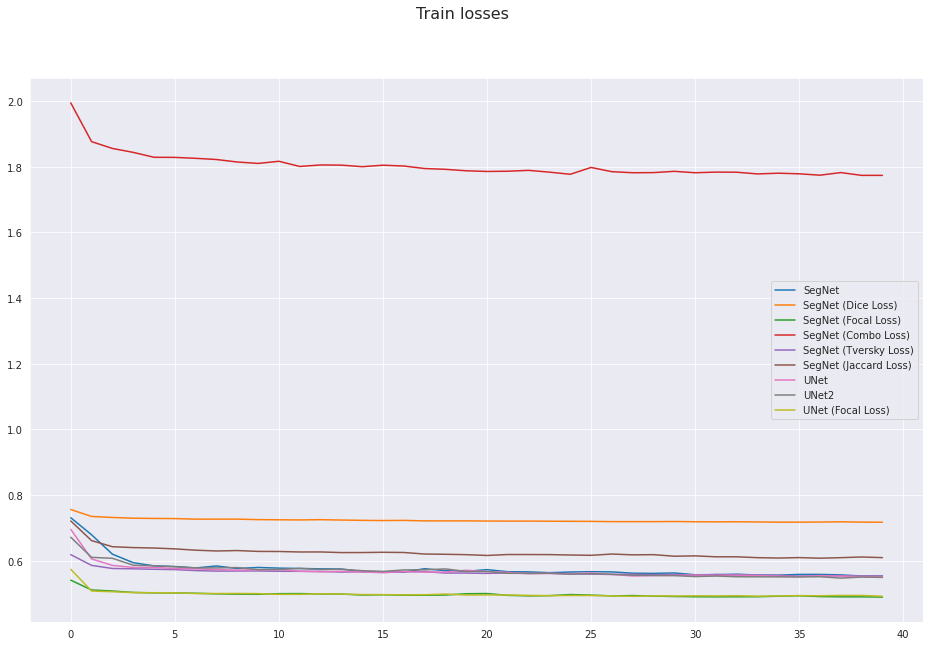

In [92]:
model_names = ['SegNet', 'SegNet (Dice Loss)', 'SegNet (Focal Loss)', 'SegNet (Combo Loss)', 
               'SegNet (Tversky Loss)', 'SegNet (Jaccard Loss)', 'UNet', 'UNet2', 'UNet (Focal Loss)']
model_history = [history_segnet, history_dice, history_focal, history_ensemble, history_tversky, history_jaccard, history_unet, history_unet2, history_unet_focal]

fig = plt.figure(figsize=(16, 10))
fig.suptitle('Train losses', fontsize=16)

for model_data in list(zip(model_history, model_names)):
    plt.plot(model_data[0], label=model_data[1])
plt.legend()
plt.show()

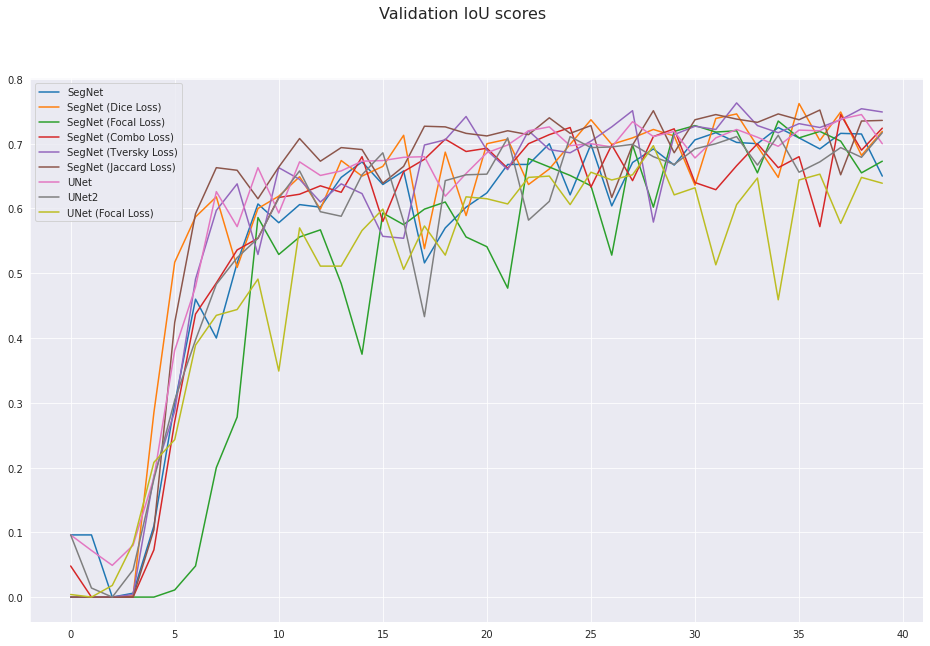

In [93]:
model_names = ['SegNet', 'SegNet (Dice Loss)', 'SegNet (Focal Loss)', 'SegNet (Combo Loss)', 
               'SegNet (Tversky Loss)', 'SegNet (Jaccard Loss)', 'UNet', 'UNet2', 'UNet (Focal Loss)']
model_iou_scores = [val_iou_segnet, val_iou_dice, val_iou_focal, val_iou_ensemble, val_iou_tversky, val_iou_jaccard, val_iou_unet, val_iou_unet2, val_iou_unet_focal]

fig = plt.figure(figsize=(16, 10))
fig.suptitle('Validation IoU scores', fontsize=16)

for model_data in list(zip(model_iou_scores, model_names)):
    plt.plot(model_data[0], label=model_data[1])
plt.legend()
plt.show()

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

**Выводы**:
* Лучший IoU Score в сравнении на архитектуре **SegNet** получился у Jacard Loss (**IoU=0.76**), которая при данном сиде, аугментациях и разбиении исходного датасета оказалась также наилучшей моделью 
Многое зависит от seed, подбора гиперпараметров (в частности learning rate для SegNet и UNet). **UNet** при других разбиениях и learning_rate достигала max **IoU = 0.76 - 0.78**
* В рамках исследовательского этапа периодически наблюдалось переобучение моделей

- В данной работе была рассмотрена и изучена задача сегментации медицинских изображений на примере двух архитектур: **SegNet** и **UNet** **UNet** является в данный момент по-прежнему остается одним из SOTA подходов к решению задачи сегментации изображений
- Архитектуры представляют собой структуры из блоков энкодера, ботлнека и декодера. В **SegNet** можно брать произвольное количество блоков энкодера и декодера (сеть несимметрична), **UNet** же требует равного количества блоков с обеих сторон архитектуры. В качестве BottleNeck в данном случае выступает свертка **Conv 1x1** (исходя из изображений архитектур и эвристик), также могут использоваться Dense слои(FCNN), блоки CNN слоев и т.д.
- Для улучшения качества и устойчивости моделей, оптимизации тренировочного процесса были расмотрены аугментации входных изображений с масками при помощи библиотеки **Albumentations** для тренировочного и валидационного датасетов (добавление аугментационных изображений в общий пул для расширения, обогащения датасета). Аугментация также позволяет разнообразить входное изображение, однако изображения с разлчным характерным волосяным покровом, разной пигментацией и т.д. в люблм случае вводят сеть в заблуждение при обучении
- В качестве оптимизатора был использован **AdamW**. Единый Learning Rate был выбран как $lr=3*10^{-4}$ исходя из эвристик задач по сегментации и соревнований на Kaggle (пул $lr=1*10^{-3}:5*10^{-4}$ ). Также был использован Cycle Test для learning rate [pytorch-lr-finder](https://github.com/davidtvs/pytorch-lr-finder). Были эксперименты с **SGD** оптимизатором, который тоже показывал хороший результат
- В функцию тренировки также был добавлен **scheduler**, который в теории может помогать бороться с переобучением и ускорением процесса сходимости

**Возможные улучшения**:
- Улучшенный подбор гиперпараметров, выбор правильного лосса
- Подбор количества блоков, слоев в архитектуре, подбор количества фильтров
- Использование предобученных CNN-слоев: VGG, DenseNet, ResNet, ResNext, GoogleNet, EfficientNet и т.д
- Использование постпроцессинга, Pyramid Network, CFR, и т.д.

